In [1]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats
import math
import mplstereonet

#load SNE
sys.path.append("../../")
from pycompass.IOTools import ccXML
from pycompass.SNE import pdf
from pycompass.SNE import SNEList
%matplotlib inline

In [2]:
#setup matplotlib
plt.style.use(['default'])
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

Probabalistic Classification
=================

Once we have a kde approximating the probability density function of a structures orientation, we can start asking probabilistic questions like "what is the probability dip > 75".

First, lets define a convenient class for loading and storing SNE data:

Synthetic Example
==================

Generate a fake SNE dataset

In [3]:
#generate a fake dataset
res = 10000
pop1 = np.array([np.random.normal(180,30,res),np.random.normal(30,1,res),np.random.normal(1.5,0.2,res)])
pop2 = np.array([np.random.normal(315,10,res),np.random.normal(45,10,res),np.random.normal(2.0,0.2,res)])
pop3 = np.array([np.random.normal(45,10,res),np.random.normal(45,10,res),np.random.normal(2.0,0.2,res)])
data = np.concatenate([pop1,pop2,pop3],axis=1)

Create a SNEList object

In [4]:
SNEs = SNEList(np.zeros(res*3),np.zeros(res*3),np.zeros(res*3),data[0],data[1],data[2])

Calculate the mean dip-dip direction (vector mean):

In [5]:
#calculate mean strike and dip
meanT, meanP = SNEs.getMeanTrendPlunge()
meanS = meanT - 90
meanD = 90 - meanP

while meanD < 0:
    meanD += 90
while meanS < 0:
    meanS += 180
while meanS > 180:
    meanS -= 180
    
print("mean plane = %02d -> %03d (dip->dipdir)" % (meanD,meanT))

mean plane = 75 -> 159 (dip->dipdir)


The SNEList class can evaluate and plot KDEs for easy visualisation and analysis:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


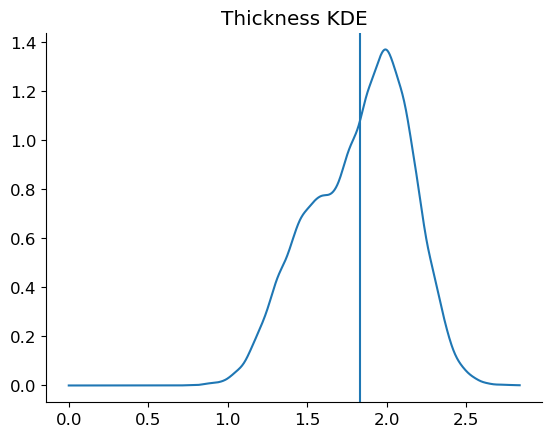

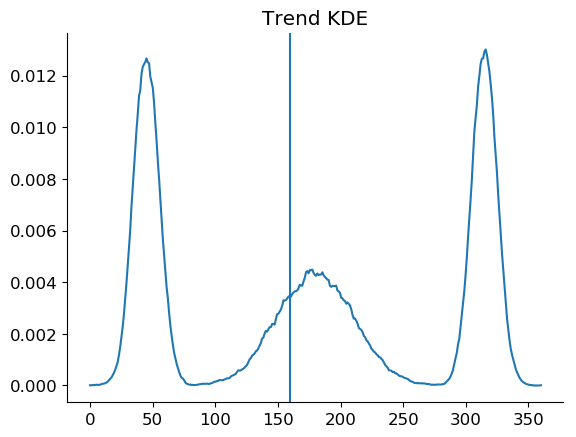

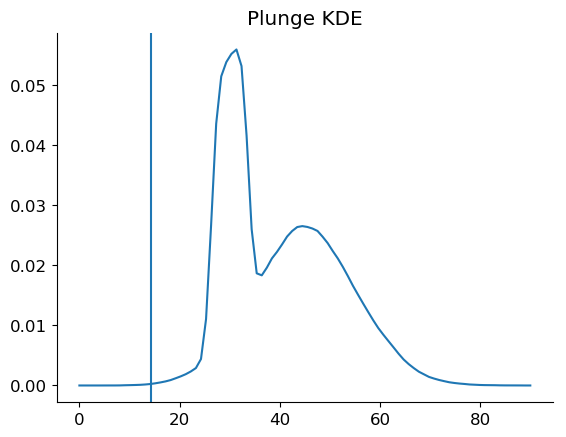

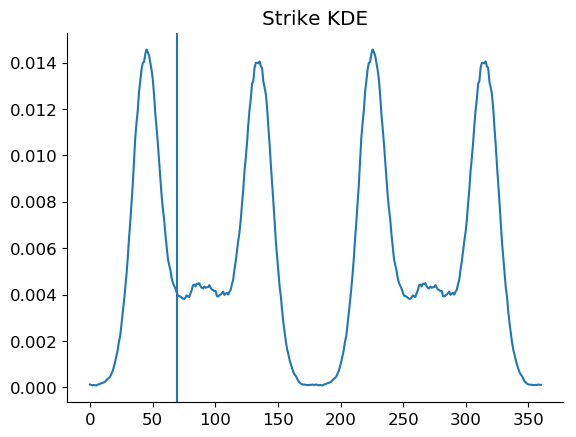

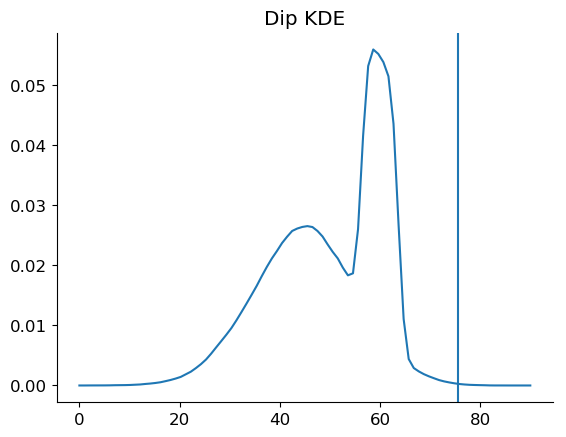

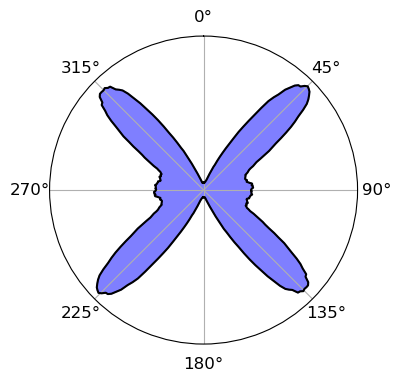

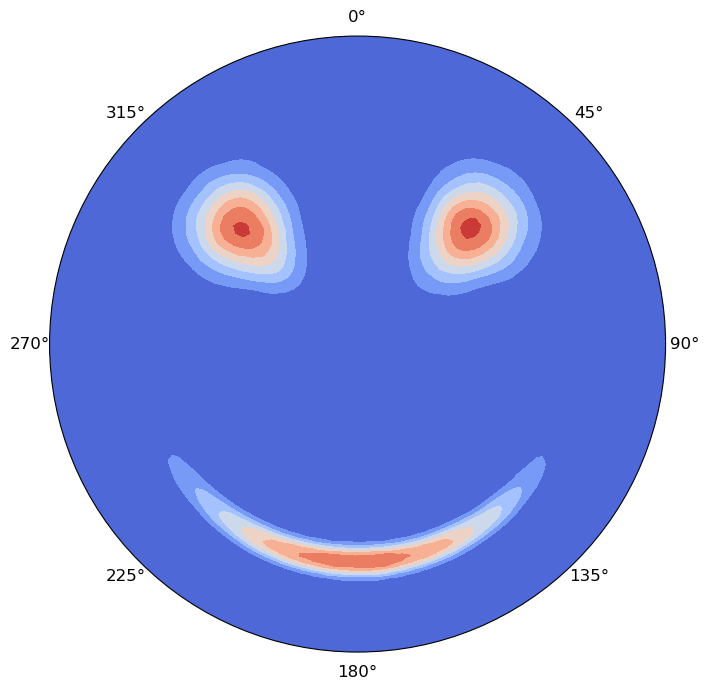

In [6]:
#1D KDEs
fig,ax = SNEs.plotKDE1D("thickness",bw=0.1)
ax.axvline( SNEs.getMeanThickness())
ax.set_title("Thickness KDE")

fig,ax = SNEs.plotKDE1D("trend",bw=0.1)
ax.axvline( meanT )
ax.set_title("Trend KDE")

fig,ax = SNEs.plotKDE1D("plunge",bw=0.1)
ax.axvline( meanP )
ax.set_title("Plunge KDE")

fig,ax = SNEs.plotKDE1D("strike",bw=0.1)
ax.axvline( meanS )
ax.set_title("Strike KDE")

fig,ax = SNEs.plotKDE1D("dip",bw=0.1)
ax.axvline( meanD )
ax.set_title("Dip KDE")

#circular visualisations
fig,ax = SNEs.plotRose(fillArgs={"alpha":0.5,"color":"b"})
fig.show()
fig,ax = SNEs.plotStereonet(cmap="coolwarm")
fig.show()

The KDEs can also be used to evaluate probabilities. For example, we can find the probability that a randomly selected SNE dips less than 50 degrees:

In [7]:
print("p(dip < 50) = ", SNEs.evalP1D("dip",0,50))

p(dip < 50) =  0.4510870442217542


Or has a pole that strikes between 045 and 180 (and hence trends between 135 and 270 OR 315 and 090)

In [8]:
print("p(45 < strike < 180) = ",SNEs.evalP1D("strike",45,180))
print("p(45 < trend < 135 | 315 < trend < 045) = ", SNEs.evalP1D("trend",135,270)+SNEs.evalP1D("trend",315,360)+SNEs.evalP1D("trend",0,90))

p(45 < strike < 180) =  0.7981989064789319
p(45 < trend < 135 | 315 < trend < 045) =  0.798150120574143


Real example
============

Now we load a real dataset:

In [9]:
data = ccXML("example_data/risco_liso_summit.xml")

And find SNES belonging to dykes, aggregating them all into a single SNEList:

In [10]:
#initialise empty SNEList
riscoliso = SNEList()

#loop through geo-objects in file
geoObjects = data.filterByKey("GEO_OBJECT")
for g in geoObjects:
    #is this geoobject a dyke?
    if "dyke" in g['@name'].lower():
        riscoliso.append(SNEList.loadFromData(data,g)) #merge SNEs from this dyke with 

...lets start with a stereonet and rose diagram to look at dyke orientation:

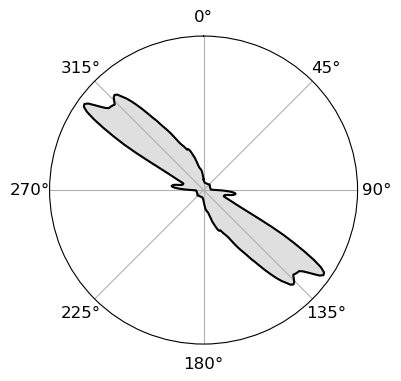

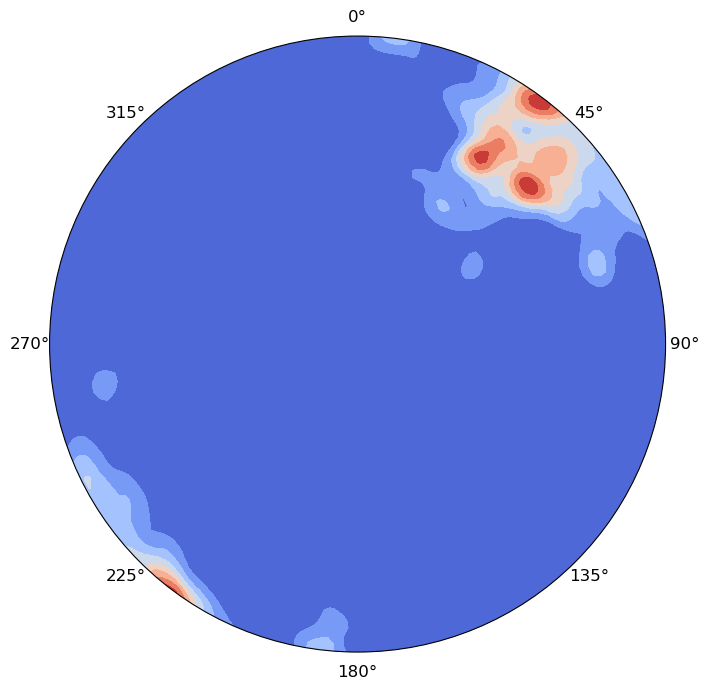

In [11]:
fig,ax = riscoliso.plotRose()
fig,ax = riscoliso.plotStereonet()

And thickness KDE to look at dyke thickness:

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


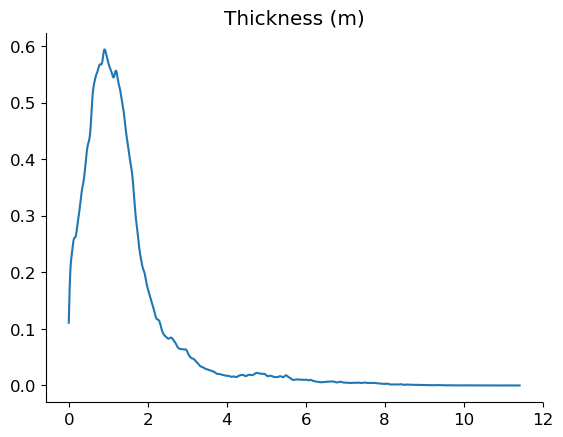

In [12]:
fig,ax = riscoliso.plotKDE1D("thick")
ax.set_title("Thickness (m)")
fig.show()

And evaluate some probabilities:

In [13]:
print("p(thickness > 2) = %.3f" % riscoliso.evalP1D("thickness",2,100))
print("p(110 < strike < 160) = %.3f" % riscoliso.evalP1D("strike",110,160))
print("p(dip > 60) = %.3f" % riscoliso.evalP1D("dip",60,90))

p(thickness > 2) = 0.173
p(110 < strike < 160) = 0.840
p(dip > 60) = 0.830
